In [1]:
from spectral_cube import SpectralCube

In [2]:
from astropy import units as u

In [3]:
cube = SpectralCube.read('/orange/adamginsburg/orion/2016.1.00165.S/external/full_OrionSourceI_B6_spw1_lines_cutout.fits')
cube

VaryingResolutionSpectralCube with shape=(1920, 1250, 1250) and unit=Jy / beam:
 n_x:   1250  type_x: RA---SIN  unit_x: deg    range:    83.809793 deg:   83.811187 deg
 n_y:   1250  type_y: DEC--SIN  unit_y: deg    range:    -5.375852 deg:   -5.374464 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 231834857246.900 Hz:233708832546.243 Hz

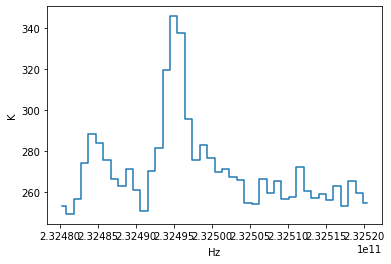

In [4]:
cube.spectral_slab(232.48*u.GHz, 232.52*u.GHz)[:, 640, 650].to(u.K).quicklook()

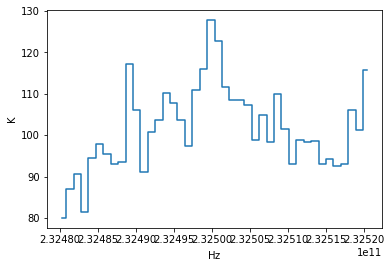

In [5]:
cube.spectral_slab(232.48*u.GHz, 232.52*u.GHz)[:, 660, 640].to(u.K).quicklook()

In [6]:
%matplotlib inline
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x2aefcaa79550>

In [7]:
from astropy.table import Table
from astropy import table

In [8]:
import pprint

In [9]:
import scipy, scipy.ndimage

In [10]:
import numpy as np
import os
import glob
from astropy import constants, units as u, table, stats, coordinates, wcs, log, coordinates as coord
import radio_beam
import pyspeckit
import pylab as pl
from astroquery.splatalogue.utils import minimize_table as mt
import sys
sys.path.append('/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis')
import lines
import paths
from salt_tables import (salt_tables, salt_table_names, SO, SO2, HCl, sis_tables, AlCl, AlF, Al37Cl,
                         NaF, AlO, AlOH, NaCN, CaS, CaO)

In [11]:
import regions
from astropy import units as u, coordinates
cen = coordinates.SkyCoord(83.810486281, -5.37517214, unit=(u.deg, u.deg), frame='icrs')
reg = regions.Regions([regions.RectangleSkyRegion(cen, 0.53*u.arcsec, 0.34*u.arcsec, 52*u.deg)])
#    box(83.810486281, -5.375172145, 0.3368", 0.5281", 322.67123) # color=#2EE6D6 width=2

#reg2 = regions.Regions.read('cutout2.reg')
#reg3 = regions.Regions.read('cutout3.reg')
#regvsm = regions.Regions.read('verysmall.reg')
#regvvsm = regions.Regions.read('innerdiskbox.reg')

In [12]:
regn = "co1"
cbflist = (glob.glob('/orange/adamginsburg/orion/2016.1.00165.S/external/full_OrionSourceI_B6_spw*_lines_cutout_smaller.fits'))
# don't need to subcube b/c reg = cutout = co1
cubes = [SpectralCube.read(fn, use_dask=True)#.subcube_from_regions(reg3)
         for fn in cbflist]
for ii,cube in enumerate(cubes):
    # continuum subtract
    with cube.use_dask_scheduler('threads', num_workers=8):
        cube.allow_huge_operations = True
        cubes[ii] = cube - cube.percentile(25, axis=0)
cubes

[DaskSpectralCube with shape=(1920, 156, 148) and unit=Jy / beam and chunk size (640, 156, 148):
  n_x:    148  type_x: RA---SIN  unit_x: deg    range:    83.810404 deg:   83.810569 deg
  n_y:    156  type_y: DEC--SIN  unit_y: deg    range:    -5.375258 deg:   -5.375086 deg
  n_s:   1920  type_s: FREQ      unit_s: Hz     range: 231834857246.900 Hz:233708832546.243 Hz,
 DaskSpectralCube with shape=(1920, 156, 148) and unit=Jy / beam and chunk size (640, 156, 148):
  n_x:    148  type_x: RA---SIN  unit_x: deg    range:    83.810404 deg:   83.810569 deg
  n_y:    156  type_y: DEC--SIN  unit_y: deg    range:    -5.375258 deg:   -5.375086 deg
  n_s:   1920  type_s: FREQ      unit_s: Hz     range: 214277229834.040 Hz:216151205133.500 Hz,
 DaskSpectralCube with shape=(1920, 156, 148) and unit=Jy / beam and chunk size (640, 156, 148):
  n_x:    148  type_x: RA---SIN  unit_x: deg    range:    83.810404 deg:   83.810569 deg
  n_y:    156  type_y: DEC--SIN  unit_y: deg    range:    -5.375258 deg:

In [32]:
topright = coordinates.SkyCoord('5:35:14.5134090216', '-5:22:30.5431496522', frame='icrs', unit=(u.h, u.deg))
trv = 19.0*u.km/u.s
bottomleft = coordinates.SkyCoord('5:35:14.5211504272', '-5:22:30.7054489346', frame='icrs', unit=(u.h, u.deg))
blv = -7.6*u.km/u.s

In [63]:
import warnings
warnings.simplefilter('ignore')

In [160]:
paths.fpath("")

'/orange/adamginsburg/orion/2016.1.00165.S/figures/'

In [147]:
doplot = True

RMS=16.858215399752773
topright vel=19.0 km / s xmin/xmax: 859.5640041873293 GHz,859.449316694157 GHz, -0.7432977881196273 km / s, 8.45288333700922 km / s
23Na-37Clv=5-5 J=71-70: guesses=[25.0, 19.0, 2]
Line 23Na-37Clv=5-5 J=71-70 with frequency 859.561137 GHz has SNR=0.0
topright vel=19.0 km / s xmin/xmax: 859.5844228133564 GHz,859.469732595825 GHz, -0.7744053955777861 km / s, 15.573972699401175 km / s
41K-37Clv=9-9 J=128-127: guesses=[25.0, 19.0, 2]
Line 41K-37Clv=9-9 J=128-127 with frequency 859.5815555579181 GHz has SNR=0.0
topright vel=19.0 km / s xmin/xmax: 859.6791717515741 GHz,859.5644688921474 GHz, -0.766610326014054 km / s, 39.07816933193933 km / s
39K-35Clv=6-6 J=119-118: guesses=[25.0, 19.0, 2]


topright vel=19.0 km / s xmin/xmax: 859.8136298245539 GHz,859.6989090250328 GHz, -0.533357312873152 km / s, 38.964690982746106 km / s
39K-37Clv=9-9 J=125-124: guesses=[132.09076819175874, 19.0, 2]
Line 39K-37Clv=9-9 J=125-124 with frequency 859.8107618045659 GHz has SNR=3.5
topright vel=19.0 km / s xmin/xmax: 860.1771582325841 GHz,860.0623889292151 GHz, -0.7877053998417988 km / s, 39.03400672903506 km / s
23Na-35Clv=4-4 J=69-68: guesses=[133.31390257347633, 19.0, 2]


topright vel=19.0 km / s xmin/xmax: 860.3517883240536 GHz,860.236995720631 GHz, -0.5082686474100343 km / s, 38.96507323079671 km / s
39K-37Clv=4-4 J=121-120: guesses=[43.26598022897334, 19.0, 2]


topright vel=19.0 km / s xmin/xmax: 860.4791826089922 GHz,860.3643730079624 GHz, -0.6948544426794191 km / s, 39.1128804418709 km / s
41K-37Clv=4-4 J=124-123: guesses=[25.0, 19.0, 2]


topright vel=19.0 km / s xmin/xmax: 860.516717221697 GHz,860.4019026126043 GHz, -0.5467135385198899 km / s, 38.919062775146415 km / s
41K-37Clv=10-10 J=129-128: guesses=[37.8727482950638, 19.0, 2]
Line 41K-37Clv=10-10 J=129-128 with frequency 860.5138468564697 GHz has SNR=inf
topright vel=19.0 km / s xmin/xmax: 860.5330298545803 GHz,860.4182130689712 GHz, -0.6473767925410289 km / s, 39.157867151159536 km / s
41K-35Clv=1-1 J=118-117: guesses=[75.9359897923891, 19.0, 2]


topright vel=19.0 km / s xmin/xmax: 860.576612565016 GHz,860.4617899643754 GHz, -0.7737041271000621 km / s, 39.0295239351609 km / s
23Na-37Clv=3-3 J=70-69: guesses=[81.64719946271154, 19.0, 2]
Line 23Na-37Clv=3-3 J=70-69 with frequency 860.573742 GHz has SNR=11.8
topright vel=19.0 km / s xmin/xmax: 860.6102049833107 GHz,860.4953779005953 GHz, -0.6380967673769357 km / s, 39.16357764530051 km / s
39K-35Clv=2-2 J=116-115: guesses=[81.64719946271154, 19.0, 2]
Line 39K-35Clv=2-2 J=116-115 with frequency 860.6073343062428 GHz has SNR=11.7
topright vel=19.0 km / s xmin/xmax: 860.8379578418868 GHz,860.7231003712022 GHz, -0.5636958121132831 km / s, 38.887352978976 km / s
41K-35Clv=6-6 J=122-121: guesses=[25.0, 19.0, 2]


topright vel=19.0 km / s xmin/xmax: 860.8434099510188 GHz,860.7285517528856 GHz, -0.7055301119101899 km / s, 39.08536191213671 km / s
39K-37Clv=10-10 J=126-125: guesses=[25.0, 19.0, 2]


topright vel=19.0 km / s xmin/xmax: 860.9539448236568 GHz,860.8390718773868 GHz, -0.641717674992897 km / s, 39.14406573527916 km / s
23Na-35Clv=2-2 J=68-67: guesses=[32.54439859288229, 19.0, 2]
Line 23Na-35Clv=2-2 J=68-67 with frequency 860.951073 GHz has SNR=0.4
topright vel=19.0 km / s xmin/xmax: 861.0239353752396 GHz,860.9090530904667 GHz, -0.7538310659613171 km / s, 39.028718254279525 km / s
39K-35Clv=7-7 J=120-119: guesses=[32.54439859288229, 19.0, 2]


topright vel=19.0 km / s xmin/xmax: 861.2397462746642 GHz,861.1248351952805 GHz, -0.7571309335795321 km / s, 39.01544960876021 km / s
39K-37Clv=0-0 J=118-117: guesses=[25.0, 19.0, 2]


topright vel=19.0 km / s xmin/xmax: 861.3786882404436 GHz,861.2637586227012 GHz, -0.6631432479903792 km / s, 39.103021903998865 km / s
23Na-37Clv=1-1 J=69-68: guesses=[38.099906343341985, 19.0, 2]
Line 23Na-37Clv=1-1 J=69-68 with frequency 861.375815 GHz has SNR=4.2


RMS=18.167749558388728
bottomleft vel=-7.6 km / s xmin/xmax: 859.6402713702889 GHz,859.5255838771167 GHz, -27.310043260714075 km / s, 8.45288333700922 km / s
23Na-37Clv=5-5 J=71-70: guesses=[25.0, -7.6, 2]
Line 23Na-37Clv=5-5 J=71-70 with frequency 859.561137 GHz has SNR=0.0
bottomleft vel=-7.6 km / s xmin/xmax: 859.6606918080148 GHz,859.5460015904833 GHz, -27.340519799918596 km / s, 12.508651806592617 km / s
41K-37Clv=9-9 J=128-127: guesses=[25.0, -7.6, 2]


bottomleft vel=-7.6 km / s xmin/xmax: 859.755449153093 GHz,859.6407462936662 GHz, -27.32979676464964 km / s, 12.514982893303738 km / s
39K-35Clv=6-6 J=119-118: guesses=[26.707473528789407, -7.6, 2]


bottomleft vel=-7.6 km / s xmin/xmax: 859.8899191562356 GHz,859.7751983567144 GHz, -27.09238978751369 km / s, 12.40565850810557 km / s
39K-37Clv=9-9 J=125-124: guesses=[51.23545998814404, -7.6, 2]
Line 39K-37Clv=9-9 J=125-124 with frequency 859.8107618045659 GHz has SNR=6.4
bottomleft vel=-7.6 km / s xmin/xmax: 860.2534798193248 GHz,860.1387105159556 GHz, -27.335513485759705 km / s, 12.486198643117156 km / s
23Na-35Clv=4-4 J=69-68: guesses=[133.1097044473179, -7.6, 2]
Line 23Na-35Clv=4-4 J=69-68 with frequency 860.174289 GHz has SNR=17.0
bottomleft vel=-7.6 km / s xmin/xmax: 860.4281254053299 GHz,860.3133328019071 GHz, -27.390975616188765 km / s, 12.42265369200252 km / s
39K-37Clv=4-4 J=121-120: guesses=[54.70635699404949, -7.6, 2]


bottomleft vel=-7.6 km / s xmin/xmax: 860.5555309936772 GHz,860.4407213926472 GHz, -27.23334436571297 km / s, 12.234153468542052 km / s
41K-37Clv=4-4 J=124-123: guesses=[50.22683808635169, -7.6, 2]


bottomleft vel=-7.6 km / s xmin/xmax: 860.5930689367439 GHz,860.4782543276509 GHz, -27.424268096965044 km / s, 12.38173042630183 km / s
41K-37Clv=10-10 J=129-128: guesses=[60.363213016794546, -7.6, 2]
Line 41K-37Clv=10-10 J=129-128 with frequency 860.5138468564697 GHz has SNR=3.0
bottomleft vel=-7.6 km / s xmin/xmax: 860.6093830170103 GHz,860.4945662314013 GHz, -27.184206088341405 km / s, 12.28082209515659 km / s
41K-35Clv=1-1 J=118-117: guesses=[73.76342685403387, -7.6, 2]
Line 41K-35Clv=1-1 J=118-117 with frequency 860.5301594349401 GHz has SNR=2.8
bottomleft vel=-7.6 km / s xmin/xmax: 860.652969594442 GHz,860.5381469938014 GHz, -27.309189501940708 km / s, 12.494038560320261 km / s
23Na-37Clv=3-3 J=70-69: guesses=[73.76342685403387, -7.6, 2]
Line 23Na-37Clv=3-3 J=70-69 with frequency 860.573742 GHz has SNR=9.7
bottomleft vel=-7.6 km / s xmin/xmax: 860.6865649933164 GHz,860.571737910601 GHz, -27.172546375828567 km / s, 12.288942785458476 km / s
39K-35Clv=2-2 J=116-115: guesses=[73.763

bottomleft vel=-7.6 km / s xmin/xmax: 860.9197906527774 GHz,860.8049324546441 GHz, -27.23279146127479 km / s, 12.558100562772111 km / s
39K-37Clv=10-10 J=126-125: guesses=[25.0, -7.6, 2]
Line 39K-37Clv=10-10 J=126-125 with frequency 860.8405384960654 GHz has SNR=0.0
bottomleft vel=-7.6 km / s xmin/xmax: 861.0303353329264 GHz,860.9154623866563 GHz, -27.16557328184094 km / s, 12.280160697574097 km / s
23Na-35Clv=2-2 J=68-67: guesses=[25.0, -7.6, 2]


bottomleft vel=-7.6 km / s xmin/xmax: 861.1003320946135 GHz,860.9854498098406 GHz, -27.275530612788543 km / s, 12.507018707452296 km / s
39K-35Clv=7-7 J=120-119: guesses=[45.799241634567245, -7.6, 2]


bottomleft vel=-7.6 km / s xmin/xmax: 861.3161621424546 GHz,861.2012510630707 GHz, -27.272184628472694 km / s, 12.50039591386705 km / s
39K-37Clv=0-0 J=118-117: guesses=[25.0, -7.6, 2]


bottomleft vel=-7.6 km / s xmin/xmax: 861.4551164362423 GHz,861.3401868184999 GHz, -4.741724289220045 km / s, 12.252363382570229 km / s
23Na-37Clv=1-1 J=69-68: guesses=[25.0, -7.6, 2]
Line 23Na-37Clv=1-1 J=69-68 with frequency 861.375815 GHz has SNR=0.0


RMS=18.59363171075338
topright vel=19.0 km / s xmin/xmax: 85.98195580397623 GHz,85.97048364492679 GHz, 1.3795518754484508 km / s, 38.83338773475346 km / s
23Na-37Clv=5-5 J=7-6: guesses=[89.12217024102766, 19.0, 2]
Line 23Na-37Clv=5-5 J=7-6 with frequency 85.981669 GHz has SNR=5.0
topright vel=19.0 km / s xmin/xmax: 86.62137393683845 GHz,86.60981646330121 GHz, 4.002054923265986 km / s, 37.79965552147739 km / s
23Na-37Clv=4-4 J=7-6: guesses=[137.32126289143224, 19.0, 2]
Line 23Na-37Clv=4-4 J=7-6 with frequency 86.62108500000001 GHz has SNR=8.8
topright vel=19.0 km / s xmin/xmax: 87.16949576516994 GHz,87.15786515837196 GHz, 1.5904324908814953 km / s, 38.534021888480034 km / s
23Na-35Clv=6-6 J=7-6: guesses=[54.578034270796394, 19.0, 2]
Line 23Na-35Clv=6-6 J=7-6 with frequency 87.169205 GHz has SNR=0.7
topright vel=19.0 km / s xmin/xmax: 87.2649270834935 GHz,87.25328374375346 GHz, 4.017181752310406 km / s, 37.565534996042736 km / s
23Na-37Clv=3-3 J=7-6: guesses=[98.73677973296566, 19.0, 2]


RMS=9.335812958073154
topright vel=19.0 km / s xmin/xmax: 497.99375925025805 GHz,497.927314336807 GHz, -0.7954766441433438 km / s, 38.88740992413112 km / s
39K-37Clv=2-2 J=68-67: guesses=[25.0, 19.0, 2]
Line 39K-37Clv=2-2 J=68-67 with frequency 497.99209812742174 GHz has SNR=4.4
topright vel=19.0 km / s xmin/xmax: 498.28668709993514 GHz,498.2202031025292 GHz, -0.8206867194650903 km / s, 39.13264597100857 km / s
23Na-35Clv=2-2 J=39-38: guesses=[44.73116981751447, 19.0, 2]
Line 23Na-35Clv=2-2 J=39-38 with frequency 498.285025 GHz has SNR=11.0
topright vel=19.0 km / s xmin/xmax: 498.29360825189383 GHz,498.2271233310319 GHz, -0.7694320191863863 km / s, 38.88957530656425 km / s
41K-37Clv=5-5 J=71-70: guesses=[44.73116981751447, 19.0, 2]
Line 41K-37Clv=5-5 J=71-70 with frequency 498.2919461288723 GHz has SNR=11.0
RMS=9.355073258222829
bottomleft vel=-7.6 km / s xmin/xmax: 498.037945117703 GHz,497.9715002042519 GHz, -27.25073435635082 km / s, 12.43215221192365 km / s
39K-37Clv=2-2 J=68-67: gu

topright vel=19.0 km / s xmin/xmax: 840.0684615664069 GHz,839.9563752697719 GHz, -0.7759786786475893 km / s, 38.9534338694044 km / s
39K-37Clv=4-4 J=118-117: guesses=[26.10779918133379, 19.0, 2]


topright vel=19.0 km / s xmin/xmax: 840.2952729825332 GHz,840.1831564235412 GHz, -0.6871915652311557 km / s, 39.03149727103569 km / s
39K-37Clv=9-9 J=122-121: guesses=[47.84926625084043, 19.0, 2]
Line 39K-37Clv=9-9 J=122-121 with frequency 840.2924700685585 GHz has SNR=9.0
topright vel=19.0 km / s xmin/xmax: 840.3397389147624 GHz,840.2276164228947 GHz, -0.501467604193082 km / s, 38.866728432771204 km / s
39K-37Clv=0-0 J=115-114: guesses=[38.76131836347461, 19.0, 2]


topright vel=19.0 km / s xmin/xmax: 840.4577124558127 GHz,840.3455742233027 GHz, -0.5694754997603855 km / s, 39.14153670650081 km / s
23Na-37Clv=8-8 J=71-70: guesses=[28.753825843463083, 19.0, 2]
Line 23Na-37Clv=8-8 J=71-70 with frequency 840.454909 GHz has SNR=2.8
topright vel=19.0 km / s xmin/xmax: 840.5557275236802 GHz,840.4435762134907 GHz, -0.7898331177289399 km / s, 38.91654848828884 km / s
41K-37Clv=9-9 J=125-124: guesses=[33.38648239462853, 19.0, 2]


topright vel=19.0 km / s xmin/xmax: 840.588153766466 GHz,840.4759981297989 GHz, -0.7186199144627912 km / s, 38.98622999167992 km / s
39K-35Clv=7-7 J=117-116: guesses=[25.0, 19.0, 2]
Line 39K-35Clv=7-7 J=117-116 with frequency 840.5853498755494 GHz has SNR=0.0
topright vel=19.0 km / s xmin/xmax: 840.7110525467991 GHz,840.5988805123384 GHz, -0.7714484177105885 km / s, 38.927597261626744 km / s
41K-37Clv=4-4 J=121-120: guesses=[199.34080168478468, 19.0, 2]
Line 41K-37Clv=4-4 J=121-120 with frequency 840.7082482459376 GHz has SNR=43.6
topright vel=19.0 km / s xmin/xmax: 840.7463039363881 GHz,840.6341271985041 GHz, -0.7375266915392141 km / s, 38.95985445889207 km / s
41K-35Clv=6-6 J=119-118: guesses=[199.34080168478468, 19.0, 2]
Line 41K-35Clv=6-6 J=119-118 with frequency 840.743499517941 GHz has SNR=47.1
topright vel=19.0 km / s xmin/xmax: 840.8725498395567 GHz,840.7603562572887 GHz, -0.6415159810918685 km / s, 39.049905132068936 km / s
23Na-35Clv=7-7 J=69-68: guesses=[169.40647936212287, 

bottomleft vel=-7.6 km / s xmin/xmax: 840.1429989536692 GHz,840.0309126570343 GHz, -27.262253710682252 km / s, 12.467158837369743 km / s
39K-37Clv=4-4 J=118-117: guesses=[41.615793285014625, -7.6, 2]
Line 39K-37Clv=4-4 J=118-117 with frequency 840.0656594089911 GHz has SNR=3.7
bottomleft vel=-7.6 km / s xmin/xmax: 840.3698304942629 GHz,840.2577139352709 GHz, -27.166317456075713 km / s, 12.552371380191126 km / s
39K-37Clv=9-9 J=122-121: guesses=[25.84172679982629, -7.6, 2]


bottomleft vel=-7.6 km / s xmin/xmax: 840.4143003718544 GHz,840.3021778799867 GHz, -27.32758348778821 km / s, 12.389003664547435 km / s
39K-37Clv=0-0 J=115-114: guesses=[26.469605901263485, -7.6, 2]


bottomleft vel=-7.6 km / s xmin/xmax: 840.532284380432 GHz,840.420146147922 GHz, -27.391825849603475 km / s, 12.319186356657722 km / s
23Na-37Clv=8-8 J=71-70: guesses=[32.06246522778848, -7.6, 2]
Line 23Na-37Clv=8-8 J=71-70 with frequency 840.454909 GHz has SNR=3.5
bottomleft vel=-7.6 km / s xmin/xmax: 840.6303081449561 GHz,840.5181568347666 GHz, -27.260754188407457 km / s, 12.44562741761032 km / s
41K-37Clv=9-9 J=125-124: guesses=[25.0, -7.6, 2]


bottomleft vel=-7.6 km / s xmin/xmax: 840.6627372648496 GHz,840.5505816281825 GHz, -27.188519851891268 km / s, 12.516330054251446 km / s
39K-35Clv=7-7 J=117-116: guesses=[33.9087480705178, -7.6, 2]


bottomleft vel=-7.6 km / s xmin/xmax: 840.7856469497156 GHz,840.6734749152548 GHz, -27.23747887060214 km / s, 12.461566808735189 km / s
41K-37Clv=4-4 J=121-120: guesses=[179.04125494718218, -7.6, 2]
Line 41K-37Clv=4-4 J=121-120 with frequency 840.7082482459376 GHz has SNR=21.6
bottomleft vel=-7.6 km / s xmin/xmax: 840.8209014670811 GHz,840.708724729197 GHz, -27.2024474584934 km / s, 12.494933691937877 km / s
41K-35Clv=6-6 J=119-118: guesses=[181.26709595427297, -7.6, 2]


bottomleft vel=-7.6 km / s xmin/xmax: 840.947158571765 GHz,840.8349649894968 GHz, -27.10246338986574 km / s, 12.240787362653306 km / s
23Na-35Clv=7-7 J=69-68: guesses=[129.92399503027468, -7.6, 2]
Line 23Na-35Clv=7-7 J=69-68 with frequency 840.869745 GHz has SNR=6.3
bottomleft vel=-7.6 km / s xmin/xmax: 841.207740931393 GHz,841.0955125839578 GHz, -27.159535172279355 km / s, 12.519590661526077 km / s
39K-35Clv=3-3 J=114-113: guesses=[40.669446566507425, -7.6, 2]
Line 39K-35Clv=3-3 J=114-113 with frequency 841.1303033716628 GHz has SNR=1.7
bottomleft vel=-7.6 km / s xmin/xmax: 841.3646191567724 GHz,841.2523698796869 GHz, -27.283718453970796 km / s, 12.388008933663157 km / s
41K-37Clv=0-0 J=118-117: guesses=[28.108402304075934, -7.6, 2]
Line 41K-37Clv=0-0 J=118-117 with frequency 841.2871671555833 GHz has SNR=1.8
bottomleft vel=-7.6 km / s xmin/xmax: 841.4439798877139 GHz,841.331720022847 GHz, -22.31988093644202 km / s, 12.47659779285706 km / s
41K-35Clv=2-2 J=116-115: guesses=[30.9898684

RMS=27.70456711850454
topright vel=19.0 km / s xmin/xmax: 87.82548295330038 GHz,87.8137648212852 GHz, 0.7587061113404567 km / s, 37.426355992144515 km / s
23Na-35Clv=5-5 J=7-6: guesses=[109.98655439642611, 19.0, 2]
Line 23Na-35Clv=5-5 J=7-6 with frequency 87.82519 GHz has SNR=5.8
topright vel=19.0 km / s xmin/xmax: 87.91261524394145 GHz,87.90088548628357 GHz, 1.5088321104351463 km / s, 38.14013980851976 km / s
23Na-37Clv=2-2 J=7-6: guesses=[155.5912189512353, 19.0, 2]
Line 23Na-37Clv=2-2 J=7-6 with frequency 87.912322 GHz has SNR=6.3
topright vel=19.0 km / s xmin/xmax: 88.00552155018985 GHz,87.99377939649015 GHz, 1.9669969746492568 km / s, 38.55963346857157 km / s
39K-37Clv=3-3 J=12-11: guesses=[65.49220459795552, 19.0, 2]
Line 39K-37Clv=3-3 J=12-11 with frequency 88.00522799634737 GHz has SNR=4.2
topright vel=19.0 km / s xmin/xmax: 88.48578515582412 GHz,88.47397892286011 GHz, 1.2980516121253631 km / s, 37.69207867390796 km / s
23Na-35Clv=4-4 J=7-6: guesses=[87.48338838938776, 19.0, 2]

bottomleft vel=-7.6 km / s xmin/xmax: 89.09112060243339 GHz,89.07923465708382 GHz, -25.71315169566966 km / s, 13.723160323023455 km / s
39K-37Clv=1-1 J=12-11: guesses=[36.77643135896177, -7.6, 2]
Line 39K-37Clv=1-1 J=12-11 with frequency 89.08291930014218 GHz has SNR=0.0
bottomleft vel=-7.6 km / s xmin/xmax: 89.15831548793085 GHz,89.14642057788613 GHz, -23.056775320068557 km / s, 13.06593265954594 km / s
23Na-35Clv=3-3 J=7-6: guesses=[92.81727448754364, -7.6, 2]
Line 23Na-35Clv=3-3 J=7-6 with frequency 89.15010799999999 GHz has SNR=5.9
bottomleft vel=-7.6 km / s xmin/xmax: 89.22832193238918 GHz,89.21641768254979 GHz, -24.082606538091923 km / s, 12.011760413751418 km / s
23Na-37Clv=0-0 J=7-6: guesses=[137.07809384583032, -7.6, 2]
Line 23Na-37Clv=0-0 J=7-6 with frequency 89.220108 GHz has SNR=9.2
RMS=21.614886957293976
topright vel=19.0 km / s xmin/xmax: 232.1626208652445 GHz,232.1316445227434 GHz, -0.19476718602376641 km / s, 38.896561775084926 km / s
39K-35Clv=4-4 J=31-30: guesses=[56.

topright vel=19.0 km / s xmin/xmax: 497.4000527824657 GHz,497.33368708441475 GHz, -0.5766335232343016 km / s, 38.85932115636784 km / s
41K-37Clv=3-3 J=70-69: guesses=[78.86719865135856, 19.0, 2]
Line 41K-37Clv=3-3 J=70-69 with frequency 497.3983936400145 GHz has SNR=51.4
topright vel=19.0 km / s xmin/xmax: 497.48444445543885 GHz,497.4180674974126 GHz, -0.33139841348010834 km / s, 39.09786647666672 km / s
39K-35Clv=9-9 J=69-68: guesses=[25.0, 19.0, 2]
Line 39K-35Clv=9-9 J=69-68 with frequency 497.4827850314882 GHz has SNR=2.9
topright vel=19.0 km / s xmin/xmax: 497.5187621340789 GHz,497.45238059720975 GHz, -0.24835056890563728 km / s, 39.178194582922764 km / s
39K-35Clv=2-2 J=66-65: guesses=[25.0, 19.0, 2]
Line 39K-35Clv=2-2 J=66-65 with frequency 497.51710259565715 GHz has SNR=4.7
topright vel=19.0 km / s xmin/xmax: 497.5273225669762 GHz,497.4609398879296 GHz, -0.38614260490937324 km / s, 39.03972417554355 km / s
23Na-37Clv=6-6 J=41-40: guesses=[25.0, 19.0, 2]
Line 23Na-37Clv=6-6 J=41-

bottomleft vel=-7.6 km / s xmin/xmax: 496.86512369121834 GHz,496.7988352478093 GHz, -27.03818368011884 km / s, 12.443730904414638 km / s
39K-37Clv=0-0 J=67-66: guesses=[25.0, -7.6, 2]
Line 39K-37Clv=0-0 J=67-66 with frequency 496.8193846652661 GHz has SNR=5.7
bottomleft vel=-7.6 km / s xmin/xmax: 496.9112936148502 GHz,496.84499901175667 GHz, -26.87450577824261 km / s, 12.603740391013071 km / s
39K-37Clv=7-7 J=70-69: guesses=[25.0, -7.6, 2]


bottomleft vel=-7.6 km / s xmin/xmax: 497.23258856702597 GHz,497.1662510988948 GHz, -26.871953271348488 km / s, 12.580783384841107 km / s
41K-35Clv=10-10 J=71-70: guesses=[25.0, -7.6, 2]
Line 41K-35Clv=10-10 J=71-70 with frequency 497.18681571401544 GHz has SNR=1.6
bottomleft vel=-7.6 km / s xmin/xmax: 497.44418597166964 GHz,497.3778202736187 GHz, -27.063468755778747 km / s, 12.372485923823396 km / s
41K-37Clv=3-3 J=70-69: guesses=[109.86484695749756, -7.6, 2]
Line 41K-37Clv=3-3 J=70-69 with frequency 497.3983936400145 GHz has SNR=68.8
bottomleft vel=-7.6 km / s xmin/xmax: 497.52858513252636 GHz,497.4622081745001 GHz, -26.813740503853072 km / s, 12.615524386256967 km / s
39K-35Clv=9-9 J=69-68: guesses=[25.0, -7.6, 2]
Line 39K-35Clv=9-9 J=69-68 with frequency 497.4827850314882 GHz has SNR=2.2
bottomleft vel=-7.6 km / s xmin/xmax: 497.5629058560969 GHz,497.4965243192278 GHz, -26.72886596936324 km / s, 12.109223284675572 km / s
39K-35Clv=2-2 J=66-65: guesses=[25.663769579575117, -7.6, 2]


topright vel=19.0 km / s xmin/xmax: 334.855510854465 GHz,334.81083269329525 GHz, -0.18465480735198903 km / s, 39.15922567535134 km / s
41K-35Clv=1-1 J=45-44: guesses=[132.7340269350618, 19.0, 2]
Line 41K-35Clv=1-1 J=45-44 with frequency 334.8543939004358 GHz has SNR=1.8
topright vel=19.0 km / s xmin/xmax: 335.0518349677618 GHz,335.0071306120093 GHz, -0.15374359759244982 km / s, 39.167083280733024 km / s
39K-37Clv=0-0 J=45-44: guesses=[159.4698220765405, 19.0, 2]
Line 39K-37Clv=0-0 J=45-44 with frequency 335.050717358868 GHz has SNR=2.5
topright vel=19.0 km / s xmin/xmax: 335.1350763677073 GHz,335.090360905455 GHz, 0.0550119930626019 km / s, 39.36607229991534 km / s
39K-35Clv=1-1 J=44-43: guesses=[159.68842403179647, 19.0, 2]


topright vel=19.0 km / s xmin/xmax: 335.50768212943115 GHz,335.4629169521832 GHz, -0.34026660638210643 km / s, 38.927135899621355 km / s
23Na-35Clv=1-1 J=26-25: guesses=[152.24192506825628, 19.0, 2]
Line 23Na-35Clv=1-1 J=26-25 with frequency 335.506563 GHz has SNR=2.2
RMS=61.566793046109495
bottomleft vel=-7.6 km / s xmin/xmax: 334.33007438513243 GHz,334.2854702880463 GHz, -26.824484660353193 km / s, 12.58472543658229 km / s
39K-35Clv=5-5 J=45-44: guesses=[223.05806390411968, -7.6, 2]
Line 39K-35Clv=5-5 J=45-44 with frequency 334.299297558143 GHz has SNR=3.8
bottomleft vel=-7.6 km / s xmin/xmax: 334.35868778479534 GHz,334.3140798702995 GHz, -26.561735368170034 km / s, 11.968416928935339 km / s
41K-37Clv=7-7 J=48-47: guesses=[132.57232017578352, -7.6, 2]
Line 41K-37Clv=7-7 J=48-47 with frequency 334.3279083237932 GHz has SNR=1.9
bottomleft vel=-7.6 km / s xmin/xmax: 334.885221831643 GHz,334.84054367047315 GHz, -26.41390846248754 km / s, 12.055663565044602 km / s
41K-35Clv=1-1 J=45-44: g

topright vel=19.0 km / s xmin/xmax: 483.40904686779123 GHz,483.34454792240496 GHz, -0.1751155049965469 km / s, 39.19094593519037 km / s
41K-37Clv=3-3 J=68-67: guesses=[29.072747877864472, 19.0, 2]
Line 41K-37Clv=3-3 J=68-67 with frequency 483.40743439415655 GHz has SNR=2.9
topright vel=19.0 km / s xmin/xmax: 483.4229307701501 GHz,483.35842997230156 GHz, -0.6492885053783152 km / s, 38.71564234186709 km / s
41K-35Clv=10-10 J=69-68: guesses=[30.062614520331316, 19.0, 2]
Line 41K-35Clv=10-10 J=69-68 with frequency 483.4213182502039 GHz has SNR=2.9
topright vel=19.0 km / s xmin/xmax: 483.54429592477544 GHz,483.47977893375764 GHz, -0.48131332314627423 km / s, 38.873737289876416 km / s
23Na-35Clv=6-6 J=39-38: guesses=[30.52562553544432, 19.0, 2]


topright vel=19.0 km / s xmin/xmax: 483.56490908773014 GHz,483.5003893463971 GHz, -0.4160565945055834 km / s, 38.93731641111398 km / s
39K-37Clv=2-2 J=66-65: guesses=[30.52562553544432, 19.0, 2]


topright vel=19.0 km / s xmin/xmax: 483.85580428845964 GHz,483.79124573437826 GHz, -0.49151497837877034 km / s, 38.838198690602304 km / s
39K-37Clv=9-9 J=69-68: guesses=[30.541489562918052, 19.0, 2]
Line 39K-37Clv=9-9 J=69-68 with frequency 483.8541903246076 GHz has SNR=3.4
topright vel=19.0 km / s xmin/xmax: 484.0270386937538 GHz,483.9624572926889 GHz, -0.28389496718854773 km / s, 39.031905016039815 km / s
39K-35Clv=4-4 J=65-64: guesses=[112.6209865391048, 19.0, 2]
Line 39K-35Clv=4-4 J=65-64 with frequency 484.02542415872716 GHz has SNR=0.0
topright vel=19.0 km / s xmin/xmax: 484.15015294569014 GHz,484.0855551180824 GHz, -0.2425646606033025 km / s, 39.063237731396256 km / s
23Na-37Clv=3-3 J=39-38: guesses=[60.18459729949413, 19.0, 2]
Line 23Na-37Clv=3-3 J=39-38 with frequency 484.14853800000003 GHz has SNR=7.3
topright vel=19.0 km / s xmin/xmax: 484.43241406226616 GHz,484.36777857391445 GHz, -0.22209988985657192 km / s, 39.06080044326125 km / s
41K-35Clv=5-5 J=67-66: guesses=[25.0, 19

topright vel=19.0 km / s xmin/xmax: 484.79466698536146 GHz,484.7299831633436 GHz, -0.25530488115844724 km / s, 38.99824210621853 km / s
39K-37Clv=4-4 J=67-66: guesses=[38.264756640718105, 19.0, 2]
Line 39K-37Clv=4-4 J=67-66 with frequency 484.793049889811 GHz has SNR=7.5
topright vel=19.0 km / s xmin/xmax: 484.8591281299033 GHz,484.79443570714477 GHz, -0.25055435627027955 km / s, 38.997773942998485 km / s
41K-35Clv=0-0 J=65-64: guesses=[41.271773453156996, 19.0, 2]
Line 41K-35Clv=0-0 J=65-64 with frequency 484.8575108193344 GHz has SNR=6.7
RMS=10.08957711461371
bottomleft vel=-7.6 km / s xmin/xmax: 483.2751455582392 GHz,483.2106701994148 GHz, -26.844223828477936 km / s, 12.536238617933279 km / s
41K-35Clv=3-3 J=66-65: guesses=[25.0, -7.6, 2]


bottomleft vel=-7.6 km / s xmin/xmax: 483.3308919017603 GHz,483.2664091056291 GHz, -26.79336486762085 km / s, 12.582555521076618 km / s
41K-37Clv=10-10 J=71-70: guesses=[38.07133218254151, -7.6, 2]
Line 41K-37Clv=10-10 J=71-70 with frequency 483.2863987724297 GHz has SNR=2.6
bottomleft vel=-7.6 km / s xmin/xmax: 483.3445771198407 GHz,483.28009249791864 GHz, -26.7851341577733 km / s, 12.58967135742988 km / s
39K-35Clv=9-9 J=67-66: guesses=[38.07133218254151, -7.6, 2]
Line 39K-35Clv=9-9 J=67-66 with frequency 483.30008273071445 GHz has SNR=1.9
bottomleft vel=-7.6 km / s xmin/xmax: 483.4519386664731 GHz,483.3874397210868 GHz, -26.82291094146396 km / s, 12.543150498760806 km / s
41K-37Clv=3-3 J=68-67: guesses=[25.0, -7.6, 2]
Line 41K-37Clv=3-3 J=68-67 with frequency 483.40743439415655 GHz has SNR=3.0
bottomleft vel=-7.6 km / s xmin/xmax: 483.4658238007195 GHz,483.40132300287087 GHz, -27.296318617393013 km / s, 12.674226550610108 km / s
41K-35Clv=10-10 J=69-68: guesses=[25.0, -7.6, 2]
Line 

bottomleft vel=-7.6 km / s xmin/xmax: 484.069985325462 GHz,484.00540392439706 GHz, -26.897667263497503 km / s, 12.418132719693055 km / s
39K-35Clv=4-4 J=65-64: guesses=[206.59033712073276, -7.6, 2]
Line 39K-35Clv=4-4 J=65-64 with frequency 484.02542415872716 GHz has SNR=56.2
bottomleft vel=-7.6 km / s xmin/xmax: 484.1931105010493 GHz,484.1285126734416 GHz, -26.849569356759226 km / s, 12.456233035240336 km / s
23Na-37Clv=3-3 J=39-38: guesses=[54.58617524646233, -7.6, 2]
Line 23Na-37Clv=3-3 J=39-38 with frequency 484.14853800000003 GHz has SNR=4.7
bottomleft vel=-7.6 km / s xmin/xmax: 484.47539666202005 GHz,484.4107611736684 GHz, -26.813601653808597 km / s, 12.469298679309217 km / s
41K-35Clv=5-5 J=67-66: guesses=[25.0, -7.6, 2]
Line 41K-35Clv=5-5 J=67-66 with frequency 484.43079817505736 GHz has SNR=1.5
bottomleft vel=-7.6 km / s xmin/xmax: 484.5269447520923 GHz,484.46230238653686 GHz, -26.943546925181945 km / s, 12.335174159482095 km / s
41K-37Clv=5-5 J=69-68: guesses=[25.0, -7.6, 2]


bottomleft vel=-7.6 km / s xmin/xmax: 484.83768172700337 GHz,484.7729979049855 GHz, -26.826936687993605 km / s, 12.426610299383377 km / s
39K-37Clv=4-4 J=67-66: guesses=[48.72295115570447, -7.6, 2]
Line 39K-37Clv=4-4 J=67-66 with frequency 484.793049889811 GHz has SNR=12.1
bottomleft vel=-7.6 km / s xmin/xmax: 484.90214859103776 GHz,484.83745616827923 GHz, -26.81865351273146 km / s, 12.429674786575042 km / s
41K-35Clv=0-0 J=65-64: guesses=[25.0, -7.6, 2]
Line 41K-35Clv=0-0 J=65-64 with frequency 484.8575108193344 GHz has SNR=1.9
RMS=14.277786064301877
topright vel=19.0 km / s xmin/xmax: 853.5847503432486 GHz,853.4708606331745 GHz, -0.6605371116299902 km / s, 1.0543886693991744 km / s
41K-35Clv=1-1 J=117-116: guesses=[25.0, 19.0, 2]


topright vel=19.0 km / s xmin/xmax: 853.599606735979 GHz,853.485715043688 GHz, -0.5875042488938278 km / s, 6.2720794861757625 km / s
39K-37Clv=4-4 J=120-119: guesses=[25.0, 19.0, 2]
Line 39K-37Clv=4-4 J=120-119 with frequency 853.5967594436718 GHz has SNR=0.7
topright vel=19.0 km / s xmin/xmax: 853.6991046241953 GHz,853.5851996563794 GHz, -0.626685221667673 km / s, 39.15426346632679 km / s
23Na-35Clv=5-5 J=69-68: guesses=[39.31077291605957, 19.0, 2]
Line 23Na-35Clv=5-5 J=69-68 with frequency 853.696257 GHz has SNR=5.8
topright vel=19.0 km / s xmin/xmax: 853.8985634451753 GHz,853.7846318645277 GHz, -0.5424505943505824 km / s, 38.886346710649455 km / s
41K-37Clv=4-4 J=123-122: guesses=[40.22131047401767, 19.0, 2]
Line 41K-37Clv=4-4 J=123-122 with frequency 853.8957151556592 GHz has SNR=7.4
topright vel=19.0 km / s xmin/xmax: 854.1498271697632 GHz,854.0358620642044 GHz, -0.784508859977129 km / s, 38.97544799510066 km / s
41K-35Clv=6-6 J=121-120: guesses=[75.6383539487811, 19.0, 2]
Line 41

topright vel=19.0 km / s xmin/xmax: 855.4338551673321 GHz,855.3197187400899 GHz, -0.15327528982247035 km / s, 38.86251333786815 km / s
41K-35Clv=7-7 J=122-121: guesses=[169.92423482688076, 19.0, 2]
Line 41K-35Clv=7-7 J=122-121 with frequency 855.431001756651 GHz has SNR=65.7


RMS=15.162621861179568
bottomleft vel=-7.6 km / s xmin/xmax: 853.6604870004478 GHz,853.5465972903738 GHz, -27.413379295684955 km / s, 1.0543886693991744 km / s
41K-35Clv=1-1 J=117-116: guesses=[33.38481623651459, -7.6, 2]
Line 41K-35Clv=1-1 J=117-116 with frequency 853.5819031004967 GHz has SNR=4.5
bottomleft vel=-7.6 km / s xmin/xmax: 853.6753447113526 GHz,853.5614530190616 GHz, -27.33988081566523 km / s, 6.2720794861757625 km / s
39K-37Clv=4-4 J=120-119: guesses=[33.38481623651459, -7.6, 2]
Line 39K-37Clv=4-4 J=120-119 with frequency 853.5967594436718 GHz has SNR=4.7
bottomleft vel=-7.6 km / s xmin/xmax: 853.774851427793 GHz,853.6609464599771 GHz, -27.375943822215675 km / s, 12.405004865778789 km / s
23Na-35Clv=5-5 J=69-68: guesses=[66.16572502459745, -7.6, 2]
Line 23Na-35Clv=5-5 J=69-68 with frequency 853.696257 GHz has SNR=9.0
bottomleft vel=-7.6 km / s xmin/xmax: 853.9743279463061 GHz,853.8603963656584 GHz, -27.285460940350614 km / s, 12.486195471649431 km / s
41K-37Clv=4-4 J=123-

RMS=15.513595430195688
topright vel=19.0 km / s xmin/xmax: 99.6178622883126 GHz,99.60457075580848 GHz, 2.635483785038334 km / s, 37.90138328140675 km / s
23Na-35Clv=6-6 J=8-7: guesses=[90.54970456145864, 19.0, 2]
Line 23Na-35Clv=6-6 J=8-7 with frequency 99.61753 GHz has SNR=6.4
topright vel=19.0 km / s xmin/xmax: 99.72708065262465 GHz,99.71377454763919 GHz, 2.1691564601651487 km / s, 40.33204014787787 km / s
23Na-37Clv=3-3 J=8-7: guesses=[95.48074007359686, 19.0, 2]
Line 23Na-37Clv=3-3 J=8-7 with frequency 99.72674800000001 GHz has SNR=8.1
topright vel=19.0 km / s xmin/xmax: 99.92985423885268 GHz,99.91652107876234 GHz, 1.1242666519001494 km / s, 39.2097117718785 km / s
39K-35Clv=0-0 J=13-12: guesses=[118.73350522071227, 19.0, 2]
Line 39K-35Clv=0-0 J=13-12 with frequency 99.92952090985044 GHz has SNR=9.1
topright vel=19.0 km / s xmin/xmax: 100.36754978899259 GHz,100.35415822928898 GHz, 1.7329761829231007 km / s, 39.652333459876914 km / s
23Na-35Clv=5-5 J=8-7: guesses=[81.34124855638454,

bottomleft vel=-7.6 km / s xmin/xmax: 217.5631966575562 GHz,217.5341708214452 GHz, -26.05927857025415 km / s, 12.967449104802636 km / s
41K-35Clv=0-0 J=29-28: guesses=[55.342838432649536, -7.6, 2]
Line 41K-35Clv=0-0 J=29-28 with frequency 217.54316883063962 GHz has SNR=5.0
bottomleft vel=-7.6 km / s xmin/xmax: 218.00029906447278 GHz,217.97121491306297 GHz, -26.59372938677798 km / s, 12.354747585531834 km / s
23Na-35Clv=2-2 J=17-16: guesses=[164.58591703677573, -7.6, 2]
Line 23Na-35Clv=2-2 J=17-16 with frequency 217.980231 GHz has SNR=15.9
bottomleft vel=-7.6 km / s xmin/xmax: 218.59983085385056 GHz,218.57066671689296 GHz, -26.68177674984049 km / s, 12.15988014853999 km / s
39K-35Clv=3-3 J=29-28: guesses=[104.52411166202226, -7.6, 2]
Line 39K-35Clv=3-3 J=29-28 with frequency 218.57970759934983 GHz has SNR=6.9
RMS=74.80426655426176
topright vel=19.0 km / s xmin/xmax: 333.0084017927572 GHz,332.9639700824705 GHz, 0.12439251239909402 km / s, 38.807345027359005 km / s
23Na-35Clv=2-2 J=26-25:

UnitConversionError: 'K' (temperature) and 'Jy / K' are not convertible

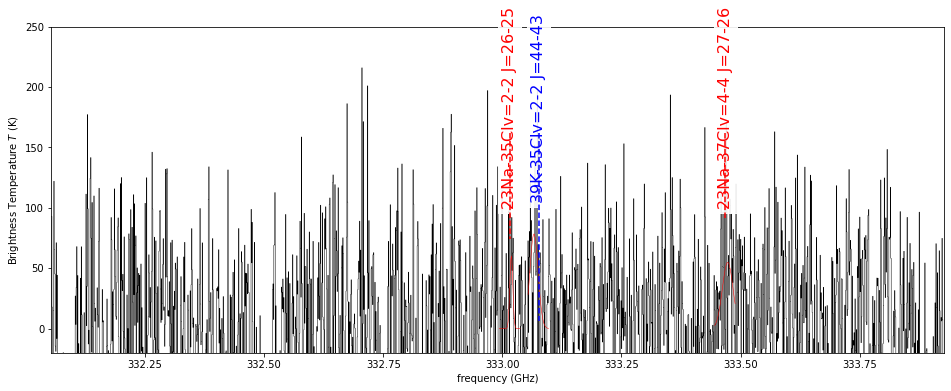

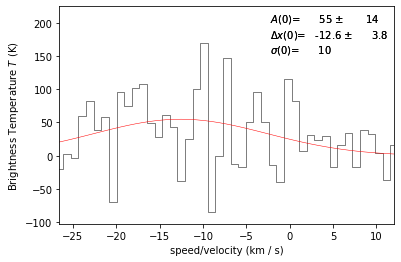

In [168]:
%run -i /orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis/line_fits.py

In [167]:
evwidths = table.Column(name='Fitted Width error', data=makecol('evwidth', unit=u.km/u.s))
#ampls = table.Column(name='Fitted Amplitude', data=u.Quantity([linefits[ln]['pars']['AMPLITUDE0'].value*1e3 for ln in linenames], u.mJy))
#amplsK = table.Column(name='Fitted Amplitude K', data=u.Quantity([linefits[ln]['pars']['AMPLITUDE0'].value*linefits[ln]['jtok'].value for ln in linenames], u.K))
amplsK = table.Column(name='Fitted Amplitude K', data=makecol('pars', parname='AMPLITUDE0', unit=u.K))
#eampls = table.Column(name='Fitted Amplitude error', data=u.Quantity([linefits[ln]['pars']['AMPLITUDE0'].error*1e3 for ln in linenames], u.mJy))
#eamplsK = table.Column(name='Fitted Amplitude error K', data=u.Quantity([linefits[ln]['pars']['AMPLITUDE0'].error*linefits[ln]['jtok'].value for ln in linenames], u.K))
eamplsK = table.Column(name='Fitted Amplitude error K', data=makecol('pars', parname='AMPLITUDE0', unit=u.K, error=True))
integrated = table.Column(name='Integrated Intensity', data=amplsK.quantity*vwidths.quantity*np.sqrt(2*np.pi))
eintegrated = table.Column(name='Integrated Intensity error',
    data=((amplsK.quantity**2*evwidths.quantity**2) + (vwidths.quantity**2*eamplsK.quantity**2))**0.5)
jtok = table.Column(name='Jy/K', data=makecol('jtok', unit=u.Jy/u.K))
eu = table.Column(name='EU_K', data=makecol('EU_K', unit=u.Jy/u.K))
species = table.Column(name='Species', data=makecol('species'))
qn = table.Column(name='QNs', data=makecol('qns'))
deg = table.Column(name='deg', data=makecol('deg'))
Aij = table.Column(name='Aij', data=makecol('aul'))
flag = table.Column(name='Flag', data=makecol('flag'))
corner = table.Column(name='Corner', data=makecol('corner'))



KeyError: 'pars'

In [144]:
tbl1

Line Name,Species,QNs,v,J$_u$,J$_l$,Frequency,Fitted Velocity,Fitted Velocity error,Fitted Width,Fitted Width error,Fitted Amplitude K,Fitted Amplitude error K,Integrated Intensity,Integrated Intensity error,Jy/K,EU_K,deg,Aij,Flag,Corner
,,,,,,GHz,km / s,km / s,km / s,km / s,K,K,K km / s,K km / s,Jy / K,K,,,,
str22,str22,str13,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,str2,str10
23Na-35Clv=1-1 J=18-17,23Na-35Clv=1-1 J=18-17,v=1-1 J=18-17,1,18,17,232.50997700000002,-7.85715892197685,0.2007623281166518,2.7314730414439135,258.85784378722855,174.67497791557702,11.118530861316987,1195.9624653248363,45215.99834601906,15424.753223047466,625.7,592,0.005799999926239252,-d,bottomleft
23Na-35Clv=1-1 J=26-25,23Na-35Clv=1-1 J=26-25,v=1-1 J=26-25,1,26,25,335.506563,-5.107847127855931,134363.32084312206,0.20058038479531734,378796589.6176161,445.3234750710014,4409553235.621097,223.89994336586386,168689332370.44424,18346.11307871118,737.2,848,0.017999999225139618,-d,bottomleft
23Na-35Clv=2-2 J=17-16,23Na-35Clv=2-2 J=17-16,v=2-2 J=17-16,2,17,16,217.980231,-7.897521899244419,0.1713828331807574,2.363821254360092,235.70614898674367,167.36452120139467,10.508610159124967,991.6718078704704,39448.85459026836,2195.913917800106,1128.4,560,0.004900000058114529,-d,bottomleft
23Na-35Clv=2-2 J=18-17,23Na-35Clv=2-2 J=18-17,v=2-2 J=18-17,2,18,17,230.779167,-7.835659447465632,0.1785323819714216,2.45207348483414,231.92154768620927,167.63721261050134,10.570213146206614,1030.3715206623092,38878.690438014484,15293.376564054412,1139.5,592,0.005799999926239252,-d,bottomleft
23Na-35Clv=2-2 J=26-25,23Na-35Clv=2-2 J=26-25,v=2-2 J=26-25,2,26,25,333.007291,-10.450485582019358,1.7383979981111641,2.8251456986497123,1565.0065954163351,60.27255274817712,32.118726342350335,426.82551213125055,94326.98621827303,17167.047557388316,1250.2,848,0.017999999225139618,-d,bottomleft
23Na-35Clv=2-2 J=27-26,23Na-35Clv=2-2 J=27-26,v=2-2 J=27-26,2,27,26,345.762037,-7.704230099177396,516003916.171508,0.05398340412384403,0.0,12.639602862182542,nan,1.7103446357891863,nan,19170.840696126437,1266.8,880,0.019999999552965164,cd,bottomleft
23Na-35Clv=3-3 J=7-6,23Na-35Clv=3-3 J=7-6,v=3-3 J=7-6,3,7,6,89.15010799999999,-7.910414723721954,0.419540416919975,2.415189175060138,1709.4447072542516,103.5425520634387,17.604982064183282,626.8446920443778,177000.27270748658,19695.147978700974,1561.0,240,0.00033000000985339284,-d,bottomleft
23Na-35Clv=4-4 J=7-6,23Na-35Clv=4-4 J=7-6,v=4-4 J=7-6,4,7,6,88.48549000000001,-7.929853407710313,0.5619002892975187,3.627696651893257,1902.9023749381668,97.38802388554853,13.06097334155151,885.5772514976484,185319.9079993923,19695.147978700974,2065.5,240,0.00031999999191612005,-d,bottomleft


In [164]:
tbl1[naclmask]

Line Name,Species,QNs,v,J$_u$,J$_l$,Frequency,Fitted Velocity,Fitted Velocity error,Fitted Width,Fitted Width error,Fitted Amplitude K,Fitted Amplitude error K,Integrated Intensity,Integrated Intensity error,Jy/K,EU_K,deg,Aij,Flag,Corner
,,,,,,GHz,km / s,km / s,km / s,km / s,K,K,K km / s,K km / s,Jy / K,K,,,,
str22,str22,str13,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,str2,str10
23Na-35Clv=1-1 J=18-17,23Na-35Clv=1-1 J=18-17,v=1-1 J=18-17,1,18,17,232.50997700000002,-7.85715892197685,0.2007623281166518,2.7314730414439135,258.85784378722855,174.67497791557702,11.118530861316987,1195.9624653248363,45215.99834601906,15424.753223047466,625.7,592,0.005799999926239252,-d,bottomleft
23Na-35Clv=1-1 J=26-25,23Na-35Clv=1-1 J=26-25,v=1-1 J=26-25,1,26,25,335.506563,-5.107847127855931,134363.32084312206,0.20058038479531734,378796589.6176161,445.3234750710014,4409553235.621097,223.89994336586386,168689332370.44424,18346.11307871118,737.2,848,0.017999999225139618,-d,bottomleft
23Na-35Clv=2-2 J=17-16,23Na-35Clv=2-2 J=17-16,v=2-2 J=17-16,2,17,16,217.980231,-7.897521899244419,0.1713828331807574,2.363821254360092,235.70614898674367,167.36452120139467,10.508610159124967,991.6718078704704,39448.85459026836,2195.913917800106,1128.4,560,0.004900000058114529,-d,bottomleft
23Na-35Clv=2-2 J=18-17,23Na-35Clv=2-2 J=18-17,v=2-2 J=18-17,2,18,17,230.779167,-7.835659447465632,0.1785323819714216,2.45207348483414,231.92154768620927,167.63721261050134,10.570213146206614,1030.3715206623092,38878.690438014484,15293.376564054412,1139.5,592,0.005799999926239252,-d,bottomleft
23Na-35Clv=2-2 J=26-25,23Na-35Clv=2-2 J=26-25,v=2-2 J=26-25,2,26,25,333.007291,-10.450485582019358,1.7383979981111641,2.8251456986497123,1565.0065954163351,60.27255274817712,32.118726342350335,426.82551213125055,94326.98621827303,17167.047557388316,1250.2,848,0.017999999225139618,-d,bottomleft
23Na-35Clv=2-2 J=27-26,23Na-35Clv=2-2 J=27-26,v=2-2 J=27-26,2,27,26,345.762037,-7.704230099177396,516003916.171508,0.05398340412384403,0.0,12.639602862182542,nan,1.7103446357891863,nan,19170.840696126437,1266.8,880,0.019999999552965164,cd,bottomleft
23Na-35Clv=3-3 J=7-6,23Na-35Clv=3-3 J=7-6,v=3-3 J=7-6,3,7,6,89.15010799999999,-7.910414723721954,0.419540416919975,2.415189175060138,1709.4447072542516,103.5425520634387,17.604982064183282,626.8446920443778,177000.27270748658,19695.147978700974,1561.0,240,0.00033000000985339284,-d,bottomleft
23Na-35Clv=4-4 J=7-6,23Na-35Clv=4-4 J=7-6,v=4-4 J=7-6,4,7,6,88.48549000000001,-7.929853407710313,0.5619002892975187,3.627696651893257,1902.9023749381668,97.38802388554853,13.06097334155151,885.5772514976484,185319.9079993923,19695.147978700974,2065.5,240,0.00031999999191612005,-d,bottomleft


In [143]:
cornertbl = Table.read(paths.tpath('corner_line_fits.txt'), format='ascii.fixed_width')
cornertbl

Line Name,v,J$_u$,J$_l$,Frequency,Fitted Velocity,Fitted Velocity error,Fitted Width,Fitted Width error,Fitted Amplitude K,Fitted Amplitude error K,Integrated Intensity,Integrated Intensity error,EU_K,Flag,Corner
str22,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str10
23Na-37Clv=5-5 J=7-6,5,7,6,85.981669,-9.513139906523481,3.4133269397470984,10.0,0.0,53.536137306195215,12.629558446750943,1341.9519548623643,126.29558446750943,2538.2,-d,bottomleft
23Na-37Clv=4-4 J=7-6,4,7,6,86.62108500000001,-8.871477212601047,1.702912927744132,2.8336779009247963,5728.642849022033,55.80678723742968,28.565291004537055,396.3943344315142,319697.16288189683,2043.6,-d,bottomleft
23Na-35Clv=6-6 J=7-6,6,7,6,87.169205,-10.196390094375769,59358.00885421362,0.7917637792278122,2521248409.407417,354.8589663717887,1473885087.9429615,704.273500479027,894688365585.3496,3060.0,-d,bottomleft
23Na-37Clv=3-3 J=7-6,3,7,6,87.264636,-8.230176438800711,3.7751653596416364,1.5078851722276325,19013.62710180957,71.28788440574445,296.7372071414251,269.4473590182884,1355441.3248210198,1544.3,-d,bottomleft
23Na-35Clv=5-5 J=7-6,5,7,6,87.82519,-8.005670789851164,0.7359382293817014,2.9276155021739174,2601.944450186565,66.74835583213871,14.806103405520698,489.8290576826219,173675.51942581098,2565.2,-d,bottomleft
23Na-37Clv=2-2 J=7-6,2,7,6,87.912322,-7.603871970924776,0.5546519766521513,2.9171578041854067,1899.6940634180742,88.76414186789776,14.644525403494526,649.0638418199321,168624.71876236456,1040.1,-d,bottomleft
39K-37Clv=3-3 J=12-11,3,12,11,88.00522799634737,-10.010842579260963,4.420129497943736,10.0,0.0,21.473802567534293,6.477650144496755,538.2684067962523,64.77650144496755,1198.3185577897405,-d,bottomleft
23Na-35Clv=4-4 J=7-6,4,7,6,88.48549000000001,-7.929853407710313,0.5619002892975187,3.627696651893257,1902.9023749381668,97.38802388554853,13.06097334155151,885.5772514976484,185319.9079993923,2065.5,-d,bottomleft
39K-37Clv=2-2 J=12-11,2,12,11,88.54307479723201,-8.298867972486493,1.2104385462525635,2.5050475326821604,3645.823234082513,38.729181940814215,15.04379171425613,243.18916903470608,141199.75638584085,811.492120004998,-d,bottomleft


In [128]:
paths.fpath('spectral_fits')

'/orange/adamginsburg/orion/2016.1.00165.S/figures/spectral_fits'

In [107]:
vwidth

<Quantity 1798.07654409 km / s>

In [90]:
row['Frequency']

347.91891499999997

In [82]:
paths.fpath('spectral_fits')

'/orange/adamginsburg/orion/2016.1.00165.S/figures/spectral_fits'

In [84]:
mkdir /orange/adamginsburg/orion/2016.1.00165.S/figures/spectral_fits

In [38]:
xx,yy

(array(73.40966848), array(73.52534677))

In [18]:
paths.dpath('')

'/orange/adamginsburg/orion/2016.1.00165.S/FITS/'

In [151]:
spwband = {spw: {band: f'{epath}/OrionSourceI_only.{band}.robust0.5.spw{spw}.*clarkclean10000_medsub.image.pbcor.fits'
    for band in ('B3', 'B6', 'B7.lb')}
    for spw in (0,1,2,3)}


In [152]:
spwband

{0: {'B3': '/orange/adamginsburg/orion/2016.1.00165.S/external//OrionSourceI_only.B3.robust0.5.spw0.*clarkclean10000_medsub.image.pbcor.fits',
  'B6': '/orange/adamginsburg/orion/2016.1.00165.S/external//OrionSourceI_only.B6.robust0.5.spw0.*clarkclean10000_medsub.image.pbcor.fits',
  'B7.lb': '/orange/adamginsburg/orion/2016.1.00165.S/external//OrionSourceI_only.B7.lb.robust0.5.spw0.*clarkclean10000_medsub.image.pbcor.fits'},
 1: {'B3': '/orange/adamginsburg/orion/2016.1.00165.S/external//OrionSourceI_only.B3.robust0.5.spw1.*clarkclean10000_medsub.image.pbcor.fits',
  'B6': '/orange/adamginsburg/orion/2016.1.00165.S/external//OrionSourceI_only.B6.robust0.5.spw1.*clarkclean10000_medsub.image.pbcor.fits',
  'B7.lb': '/orange/adamginsburg/orion/2016.1.00165.S/external//OrionSourceI_only.B7.lb.robust0.5.spw1.*clarkclean10000_medsub.image.pbcor.fits'},
 2: {'B3': '/orange/adamginsburg/orion/2016.1.00165.S/external//OrionSourceI_only.B3.robust0.5.spw2.*clarkclean10000_medsub.image.pbcor.fits